In [24]:
import numpy as np
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0664.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1269.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0733.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0106.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0375.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1075.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0285.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0591.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0799.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1411.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0074.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1031.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0077.jpg

In [25]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers

from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

# Train & Test Directories 

In [26]:
train_data = "../input/autism-image-data/AutismDataset/train"
test_data = "../input/autism-image-data/AutismDataset/test"

# Splitting Autistic & Non-Autistic

In [27]:
train_non_autistic = []
train_autistic = []

for i in os.listdir(train_data):
    if 'Non_Autistic' in ("../input/autism-image-data/AutismDataset/train/{}".format(i)):
        train_non_autistic.append(("../input/autism-image-data/AutismDataset/train/{}".format(i)))
    else:
        train_autistic.append(("../input/autism-image-data/AutismDataset/train/{}".format(i)))
        
        
test_non_autistic = []
test_autistic = []

for i in os.listdir(test_data):
    if 'Non_Autistic' in ("../input/autism-image-data/AutismDataset/test/{}".format(i)):
        test_non_autistic.append(("../input/autism-image-data/AutismDataset/test/{}".format(i)))
    else:
        test_autistic.append(("../input/autism-image-data/AutismDataset/test/{}".format(i)))

In [28]:
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

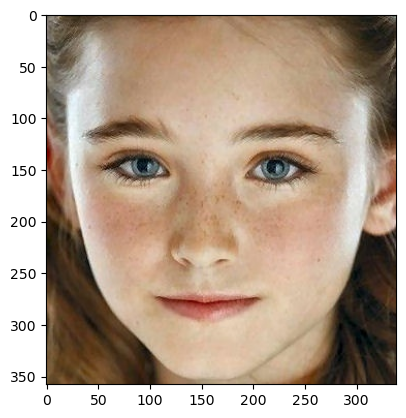

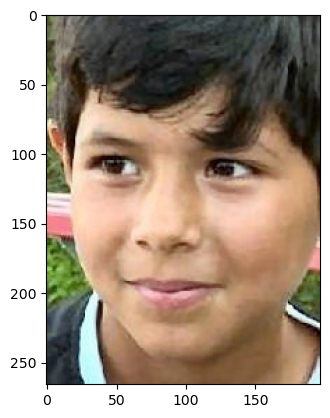

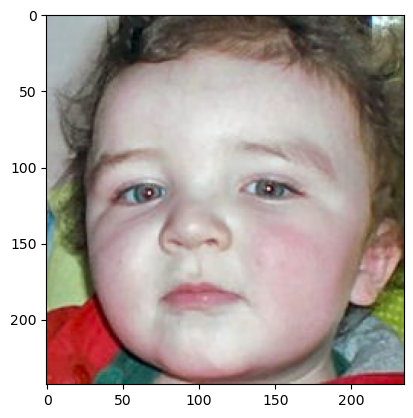

In [29]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

# Resizing The Images

In [30]:
def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (150, 150), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    return X,y

X_train, y_train = read_and_process_image(train_imgs)


# Validation Data

In [31]:
val_autistic = "../input/autism-image-data/AutismDataset/valid/Autistic"
val_non_autistic = "../input/autism-image-data/AutismDataset/valid/Non_Autistic"
val_autistic_imgs = ["../input/autism-image-data/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["../input/autism-image-data/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

In [32]:
X_val, y_val = read_and_process_image(val_imgs)

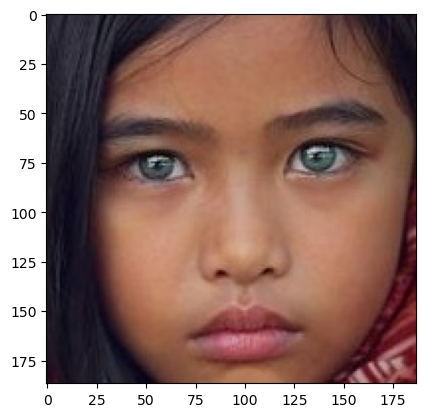

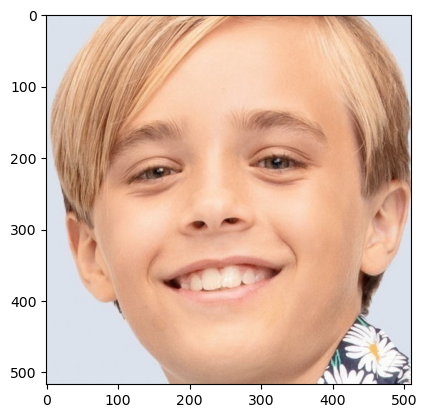

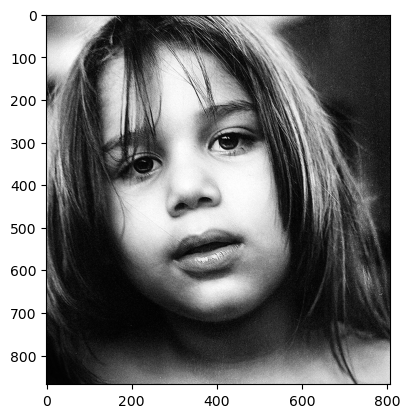

In [33]:
import matplotlib.image as mpimg
for ima in val_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

# Converting Train & Val Data To np Array


In [34]:
X_val = np.array(X_val)
y_val = np.array(y_val)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Shape Of Data

In [35]:
print("Shape of Train images:", X_train.shape)
print("Shape of Train labels:", y_train.shape)
print("Shape of validation images:", X_val.shape)
print("Shape of validation labels:", y_val.shape)

Shape of Train images: (2540, 150, 150, 3)
Shape of Train labels: (2540,)
Shape of validation images: (100, 150, 150, 3)
Shape of validation labels: (100,)


# VGG 16

In [36]:
vgg_16 = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))

# Freeze VGG16 Layers

In [37]:
for layer in vgg_16.layers:
   layer.trainable = False

In [38]:
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# Custom Model

In [39]:
model = Sequential()
model.add(vgg_16)
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


# Compile Model

In [41]:
model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['acc'])

# Generating Larger DataSet 

## Data Augmentation

In [42]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 4,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [43]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = 32)
val_generator = val_datagen.flow(X_val, y_val, batch_size = 32)

# Train Model

In [44]:
history = model.fit(train_generator,
                              epochs=40,
                              validation_data=val_generator,
                              workers=4,
                              use_multiprocessing=False
                             )

Epoch 1/40
80/80 [==============================] - 21s 230ms/step - loss: 0.7032 - acc: 0.6760 - val_loss: 0.5359 - val_acc: 0.7300
Epoch 2/40
80/80 [==============================] - 18s 225ms/step - loss: 0.5411 - acc: 0.7189 - val_loss: 0.5171 - val_acc: 0.7500
Epoch 3/40
80/80 [==============================] - 19s 233ms/step - loss: 0.5193 - acc: 0.7374 - val_loss: 0.5081 - val_acc: 0.7600
Epoch 4/40
80/80 [==============================] - 14s 166ms/step - loss: 0.5177 - acc: 0.7354 - val_loss: 0.5063 - val_acc: 0.7600
Epoch 5/40
80/80 [==============================] - 20s 241ms/step - loss: 0.5123 - acc: 0.7476 - val_loss: 0.5232 - val_acc: 0.7700
Epoch 6/40
80/80 [==============================] - 14s 168ms/step - loss: 0.5067 - acc: 0.7465 - val_loss: 0.5047 - val_acc: 0.7500
Epoch 7/40
80/80 [==============================] - 14s 171ms/step - loss: 0.5026 - acc: 0.7520 - val_loss: 0.4965 - val_acc: 0.7900
Epoch 8/40
80/80 [==============================] - 15s 177ms/step - 

# Plotting Accuracy

In [45]:
history_df = pd.DataFrame(history.history)
history_df

,loss,acc,val_loss,val_acc
0,0.703234,0.675984,0.535884,0.73
1,0.541109,0.718898,0.517136,0.75
2,0.519309,0.737402,0.508077,0.76
3,0.517729,0.735433,0.506252,0.76
4,0.512279,0.747638,0.523209,0.77
5,0.506660,0.746457,0.504676,0.75
6,0.502644,0.751969,0.496543,0.79
7,0.494632,0.759843,0.498907,0.75
8,0.489920,0.767323,0.501107,0.74
9,0.477631,0.764173,0.596153,0.71


# Training & Val Acc

Text(0.5, 1.0, 'Training and Validation Accuracy')

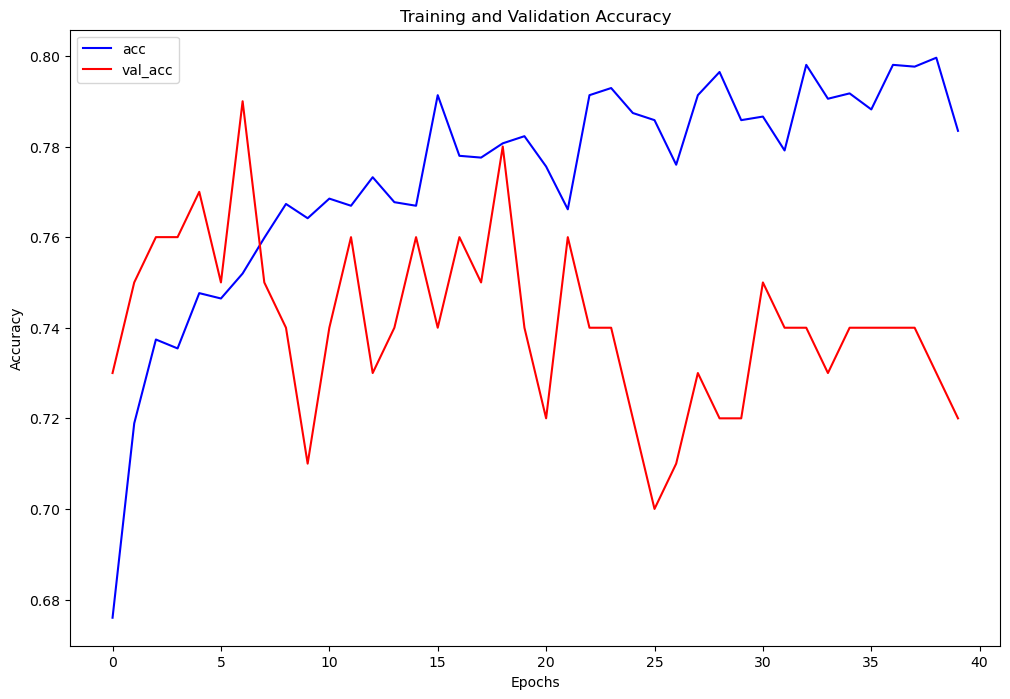

In [46]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["acc", "val_acc"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

# Training And Val Loss

Text(0.5, 1.0, 'Training and Validation Loss')

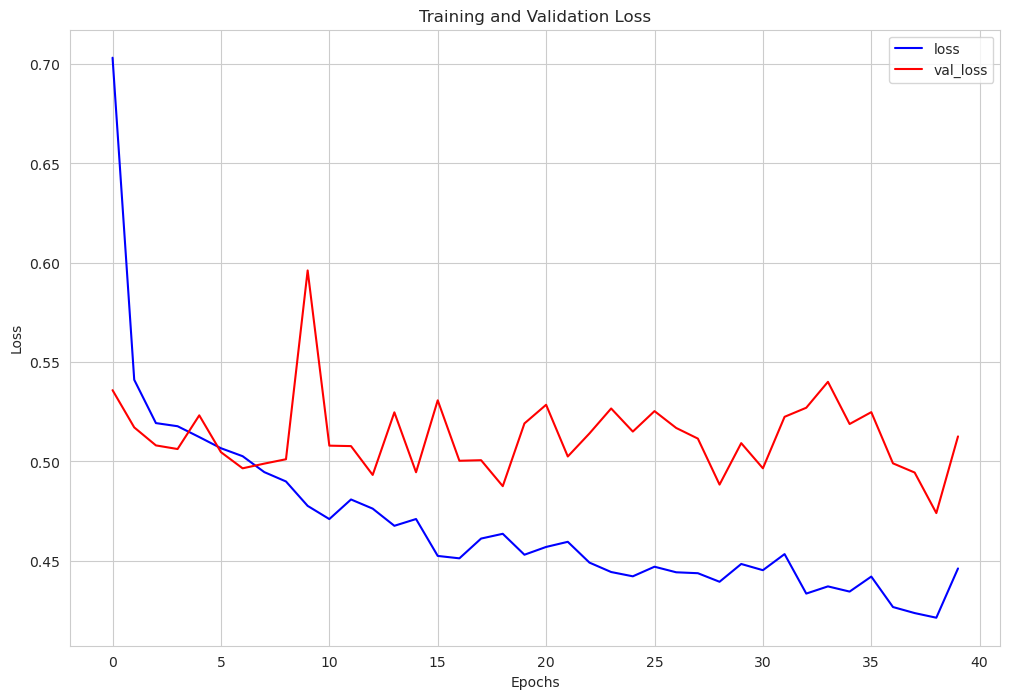

In [47]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

# Test Data

In [48]:
test_autistic = "../input/autism-image-data/AutismDataset/test/Autistic"
test_non_autistic = "../input/autism-image-data/AutismDataset/test/Non_Autistic"
test_autistic_imgs = ["../input/autism-image-data/AutismDataset/test/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
test_non_autistic_imgs = ["../input/autism-image-data/AutismDataset/test/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
test_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)
X_test, y_test = read_and_process_image(test_imgs)
X = np.array(X_test)

# Prediction

In [49]:
pred = model.predict(X)
threshold = 0.5
predictions = np.where(pred > threshold, 1,0)

4/4 [==============================] - 0s 81ms/step


## Model Accuracy

In [51]:
model_accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))

Model Accuracy: 71.00%


## Classification Report

In [52]:
cl_report = classification_report(y_test, predictions)
print(cl_report)

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        50
           1       0.86      0.50      0.63        50

    accuracy                           0.71       100
   macro avg       0.75      0.71      0.70       100
weighted avg       0.75      0.71      0.70       100



## Confusion Matrix 

In [54]:
cn_matrix= confusion_matrix(y_test, predictions)
cn_matrix

array([[46,  4],
       [25, 25]])

## Plotting the True Positives, True Negatives, False Positives and False Negatives 

Text(0.5, 1.0, 'Confusion Matrix')

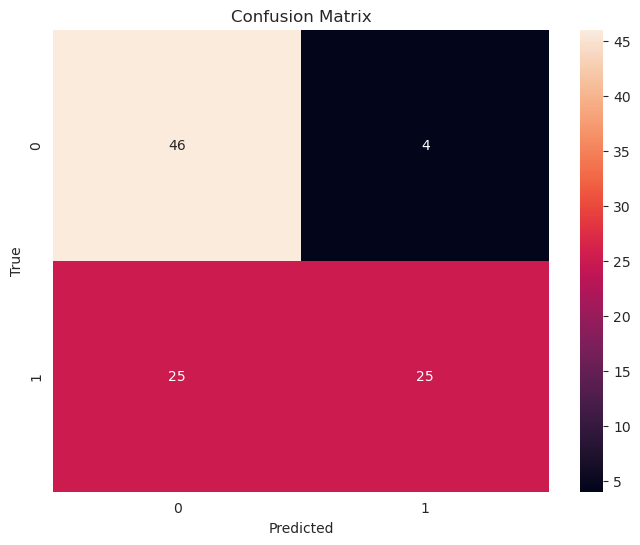

In [55]:
# Plotting the True Positives, True Negatives, False Positives and False Negatives from model's predictions
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

# Saving The Model To Use In Web Interface

In [53]:
model.save("autism_74_2.h5")